In [1]:
import matplotlib.pyplot as plt

# Cooking under a bloodmoon

This notebook demonstrates the capabilities of bloodmoon, a Python library designed for analyzing simulated data from the Wide Field Monitor (WFM) coded mask instrument. Through practical examples, we'll explore how to process, analyze, and visualize coded mask data using bloodmoon's key features.

## Loading mask data



The `CodedMaskCamera` class is the core component of bloodmoon, representing a coded mask instrument. It provides access to several key components:

* The mask pattern, the physical coded aperture that modulates incoming radiation
* The decoder pattern used to reconstruct the original sky image from detector data
* The bulk pattern, which represents the detector's sensitivity map
* The balancing array used to correct for systematic effects in image reconstruction

These components work together to enable the transformation between sky images and detector shadowgrams, as well as the reconstruction of source positions from detector data.

The `camera` function provides a simple interface to create a CodedMaskCamera instance. It takes a path to a FITS file containing the mask pattern and configuration data. This file defines all the geometric properties of the instrument, including mask dimensions, detector specifications, and the distance between mask and detector planes.


In [2]:
from bloodmoon import camera

wfm = camera("wfm_mask.fits")

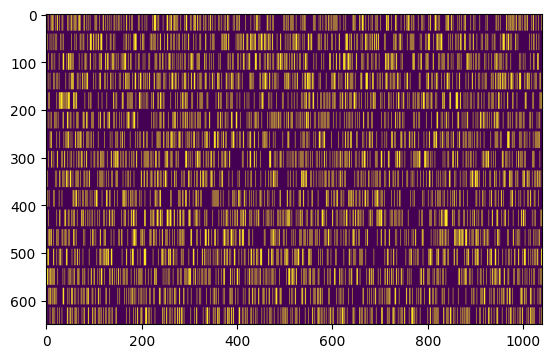

In [3]:
plt.imshow(wfm.mask); plt.show()

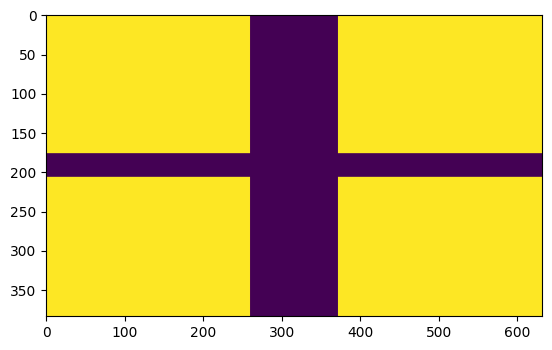

In [4]:
plt.imshow(wfm.bulk); plt.show()

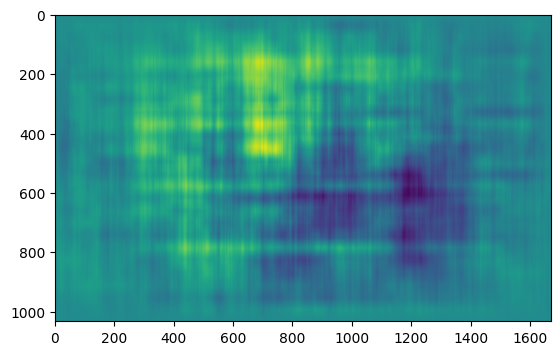

In [5]:
plt.imshow(wfm.balancing); plt.show()

### Mask upscaling

The `camera` function accepts optional parameters to increase the sampling resolution of the mask pattern if needed. By default, both are set to 1, meaning no upscaling is applied.

In [6]:
wfm_upscaled = camera("wfm_mask.fits", upscale_x=5, upscale_y=8)  # a (5, 8) upscaling results in square mask elements

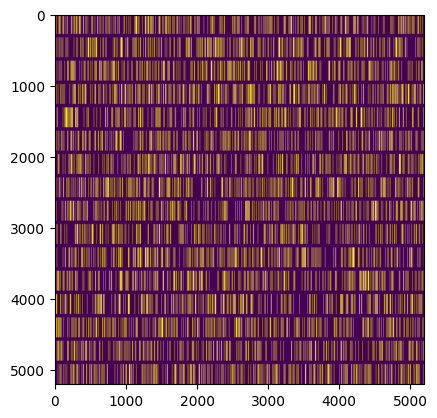

In [7]:
plt.imshow(wfm_upscaled.mask); plt.show()

### Mask parameters

The `parameters` property of a camera object provides access to essential geometric and physical characteristics of the instrument. 

In [8]:
wfm.parameters

{'mask_minx': -130.0,
 'mask_miny': -130.0,
 'mask_maxx': 130.0,
 'mask_maxy': 130.0,
 'mask_deltax': 0.25,
 'mask_deltay': 0.4,
 'mask_thickness': 0.15,
 'slit_deltax': 0.25,
 'slit_deltay': 14.0,
 'detector_minx': -78.988,
 'detector_maxx': 78.988,
 'detector_miny': -76.5255,
 'detector_maxy': 76.5255,
 'mask_detector_distance': 202.9}

## Loading simulation data

The library provides a dedicated data loader for managing WFM simulation outputs. This simulation data is organized and accessed through the SimulationDataLoader class:

1. Raw photon events before detector position reconstruction
2. Reconstructed photon events with refined position information
3. Photon events with associated astrophysical source information
4. Instrument pointing information for both cameras

Each dataset is stored in astropy's `FITSrec` objects and includes detailed header information about the simulation parameters and conditions.
For detailed information about the simulation framework and data structure, please refer to Francesco Ceraudo's WISEMAN documentation.

In [9]:
from bloodmoon import simulation

sdl = simulation("../../simulations/id00/")

## Detector images

With the camera and simulation data loader instances in hand, we can create detector images from the photon event data:

In [10]:
from bloodmoon import camera, simulation
from bloodmoon import count

wfm = camera("wfm_mask.fits")
sdl = simulation("../../simulations/id00/")

detector_counts, bins = count(wfm, sdl.reconstructed["cam1a"])

The count function generates a 2D histogram of photon events, similar to NumPy's histogram2d. It automatically:

* Determines appropriate binning based on the camera geometry and upscaling factors
* Takes into account the detector's bulk (sensitivity) pattern
* Returns both the counts array and the binning structure

This creates a detector image for further analysis and reconstruction.

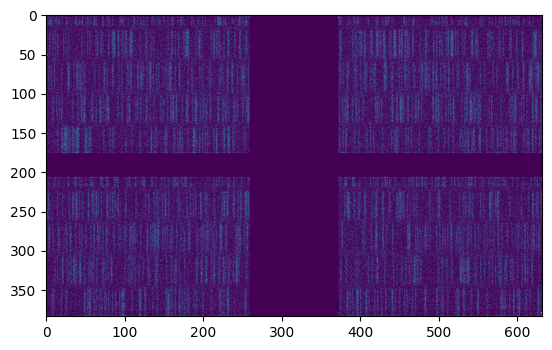

In [11]:
plt.imshow(detector_counts); plt.show()

## Reconstruction by cross-correlation

After obtaining the detector image, we can reconstruct a sky image using cross-correlation techniques. The decode function performs a balanced reconstruction that accounts for systematic effects in the coded mask system:

In [12]:
from bloodmoon import camera, simulation, count
from bloodmoon import decode

wfm = camera("wfm_mask.fits")
sdl = simulation("../../simulations/id00/")
detector, _ = count(wfm, sdl.reconstructed["cam1a"])

balanced = decode(wfm, detector)

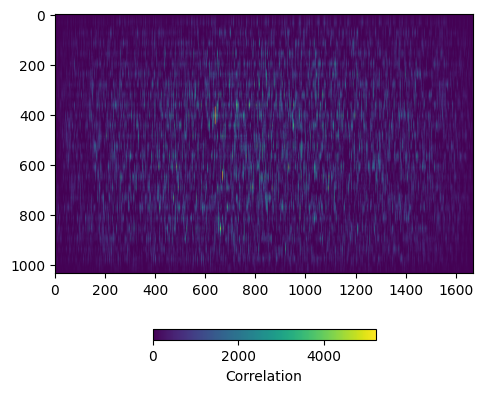

In [13]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(balanced, vmin=0, vmax=-balanced.min())
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", shrink=.45)
plt.show()

## Composing images from different cameras

A powerful feature of the WFM instrument is its ability to combine observations from multiple cameras. The compose function enables merging reconstructed images from different cameras into a single picture:

In [14]:
from bloodmoon import camera, simulation, count, decode
from bloodmoon.images import compose

wfm = camera("wfm_mask.fits", upscale_x=5, upscale_y=8)
sdl = simulation("../../simulations/id00/")
detector_1a, _ = count(wfm, sdl.reconstructed["cam1a"])
detector_1b, _ = count(wfm, sdl.reconstructed["cam1b"])
balanced_1a = decode(wfm, detector_1a)
balanced_1b = decode(wfm, detector_1b)

composed, composed_f = compose(balanced_1a, balanced_1b)

The compose function:

* Takes reconstructed images from two cameras
* Combines them into a single composite image
* Returns both the composed image and a mapping function that relates positions in the composite to the original images

Composition can enhance the overall sensitivity and angular resolution of the observations.

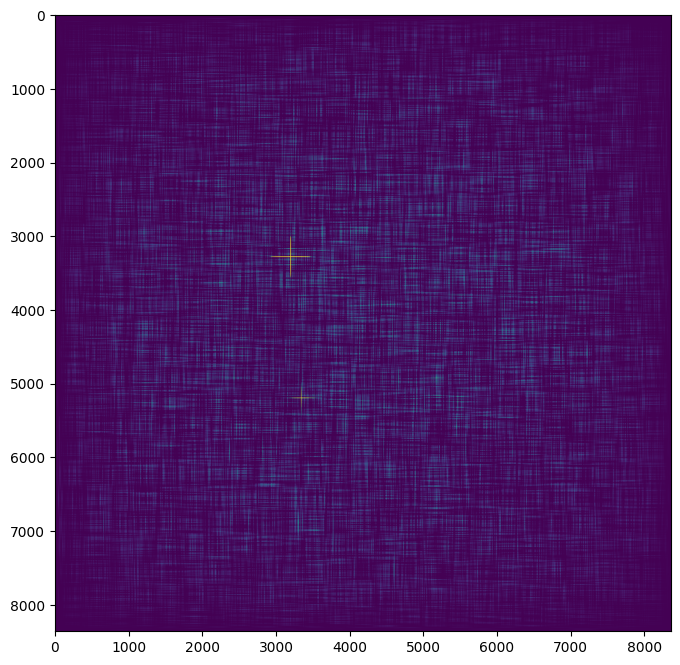

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=-composed.min())
plt.show()

The compose function returns both the composite image and a mapping function that helps us understand how positions in the composite relate to the original images. Let's demonstrate this by finding the brightest point in the composed image and tracing it back to its component images:

In [16]:
from bloodmoon.images import argmax

argmax_composed = argmax(composed)
argmax_1a, argmax_1b = composed_f(*argmax_composed)

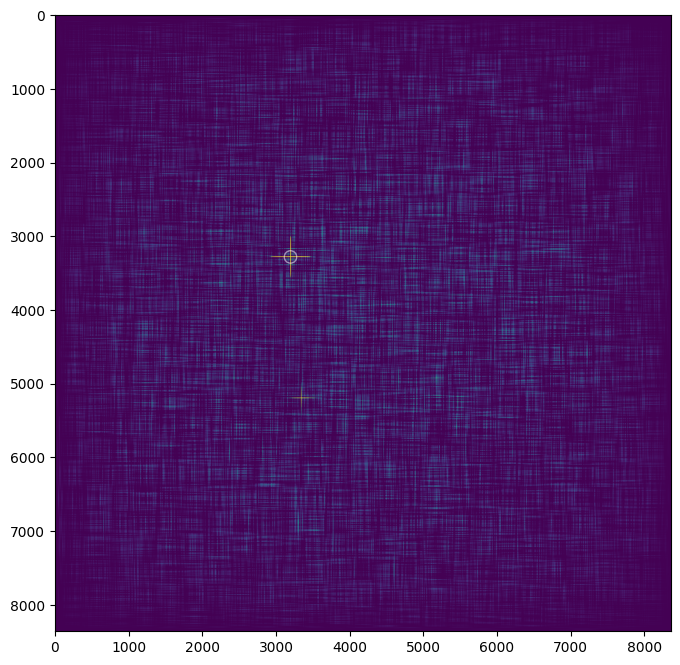

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=-composed.min())
ax.scatter(*argmax_composed[::-1], s=80, facecolors='none', edgecolors='white', alpha=0.5)
plt.show()

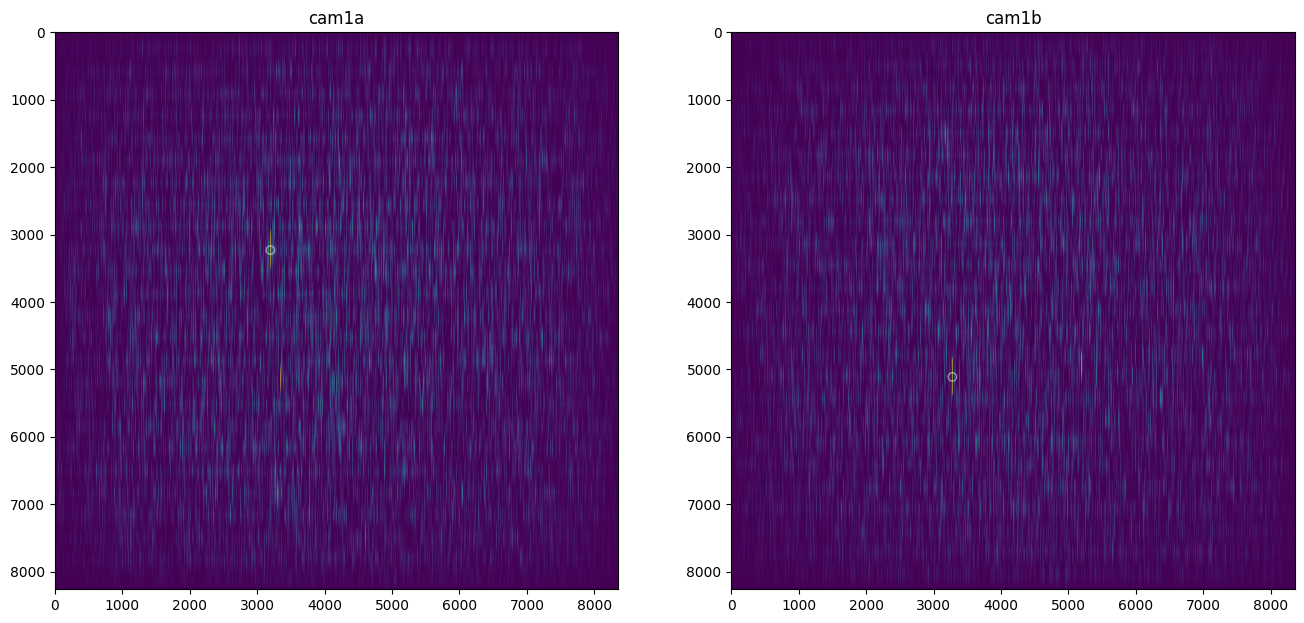

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
for ax, b, bmax, title in zip(
        axs,
        [balanced_1a, balanced_1b],
        [argmax_1a, argmax_1b],
        ["cam1a", "cam1b"],
):
    c0 = ax.imshow(b, vmin=0, vmax=-b.min())
    ax.scatter(bmax[1], bmax[0], facecolors='none', edgecolors='white', alpha=0.5)
    ax.set_title(title)
plt.show()

When working with composed images, detector pixels should be square to avoid distortions. This typically requires upscaling the camera objects, but there's an important trade-off to consider because higher resolutions result in increased memory and CPU usage. A practical alternative workflow is to:

1. Perform initial analysis and reconstruction at lower resolution, using interpolation methods on the results rather than processing the full data at high resolution
2. Upscale only the final images for visualization or precise position measurements

In [19]:
import numpy as np
from bloodmoon.images import upscale

arr = np.array([
    [1, 2],
    [3, 4],
])
# no magic here, `upscale` will just repeat elements along each dimension.
# note that, for compatibility, we use `x` and `y` and not `rows` and `cols`
upscale(arr, upscale_x=2, upscale_y=3)

array([[1, 1, 2, 2],
       [1, 1, 2, 2],
       [1, 1, 2, 2],
       [3, 3, 4, 4],
       [3, 3, 4, 4],
       [3, 3, 4, 4]])

## Simulating shadowgrams and sources

Accurate source analysis requires the ability to model detector shadowgrams that closely match real observations. The library provides functions to generate synthetic shadowgrams with varying levels of realism:

In [20]:
from bloodmoon import camera
from bloodmoon import model_shadowgram

wfm = camera("wfm_mask.fits")
sg = model_shadowgram(wfm, shift_x=0., shift_y=0., fluence=1000)

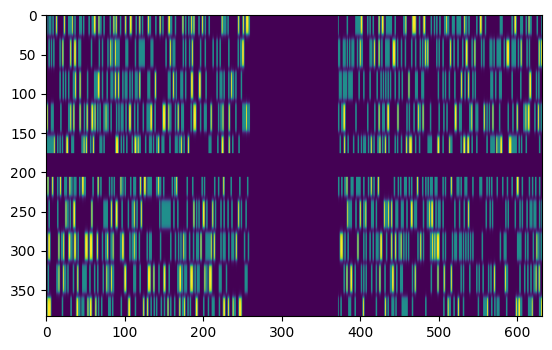

In [21]:
plt.imshow(sg); plt.show()

By default, model_shadowgram incorporates several key physical effects:

* Vignetting: The reduction in transmission at large off-axis angles due to finite mask thickness.
* Detector position reconstruction: The impact of uncertainty on position reconstruction from the detector.
* Sub-pixel sampling: The proper handling of sources that fall between mask elements.

These effects can be individually enabled or disabled through function parameters to study their impact or optimize performance for specific use cases.

In [22]:
sg = model_shadowgram(wfm, shift_x=0., shift_y=0., fluence=1000, vignetting=False, psfy=False)

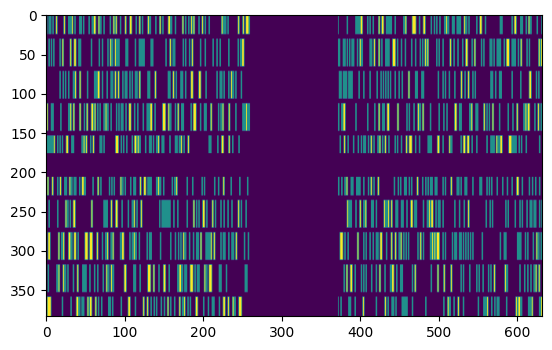

In [23]:
plt.imshow(sg); plt.show()

Source positions in shadowgram generation are specified using 'shifts' - the spatial displacement between the center of the shadow pattern and the detector center. While shifts provide a convenient way to express source positions independently of the mask-detector distance, they are primarily an implementation detail. Future versions of the library will support more intuitive ways of specifying source directions, such as sky coordinates or angular offsets from the optical axis.

In [24]:
sg = model_shadowgram(wfm, shift_x=150.02, shift_y=100.23, fluence=1000)

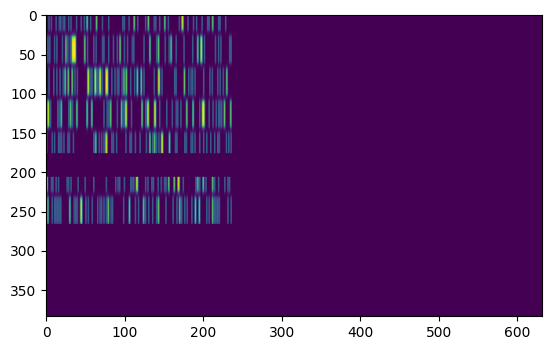

In [25]:
plt.imshow(sg); plt.show()  # remember imshow plots with graphics convention, i.e. y grows top to bottom.

The library offers two approaches to generating simulated sky images. You can either generate a shadowgram and decode it manually, or use the more direct `model_sky` function:

In [26]:
from bloodmoon import camera
from bloodmoon import model_sky

wfm = camera("wfm_mask.fits")
sky = model_sky(wfm, shift_x=150.02, shift_y=100.23, fluence=1000)

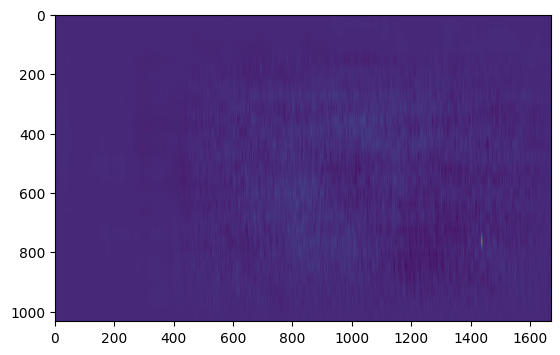

In [27]:
plt.imshow(sky); plt.show() 

The model_sky function internally handles both shadowgram generation and decoding, making it more convenient for simulation studies. Like model_shadowgram, it includes realistic instrumental effects by default and offers the same parameters for controlling which effects are included.

## Fitting sources

The library provides an optimization routine to determine source parameters (position and intensity) from sky images. The optimize function uses a two-stage approach that requires an initial position estimate:

In [28]:
from bloodmoon import camera, model_sky
from bloodmoon.images import argmax
from bloodmoon import optimize

wfm = camera("wfm_mask.fits")
simulated_sky = model_sky(wfm, shift_x=13.02, shift_y=100.35, fluence=1000)

# note optimize takes matrix indices for arguments, but returns shifts.
shift_x, shift_y, fluence = optimize(wfm, simulated_sky, argmax(simulated_sky))
print(f"source direction: x= {shift_x:+.2f}, y= {shift_y:+.2f}, fluence= {fluence:2f}")

source direction: x= +13.02, y= +100.29, fluence= 819.176458


The optimization process:

* Takes matrix indices as input position
* Returns refined source parameters in shift coordinates
* Optimizes position and intensity simultaneously
* Accounts for instrumental effects in the fitting process

Note that while the initial position is provided as array indices, the optimized results are returned in shift coordinates.

## Subtracting sources

Let's demonstrate a key analysis technique: removing a bright source from a complex field to reveal fainter objects. We'll use a simulation of the Galactic Center region where Scorpius X-1, one of the brightest X-ray sources in the sky, dominates the field:

In [29]:
from bloodmoon import camera, simulation, decode, count, model_sky, optimize
from bloodmoon.images import argmax, compose, upscale

# loads camera specs and simulation dataset
wfm = camera("wfm_mask.fits", upscale_x=5)
sdl = simulation("../../simulations/galcenter")

# computes detector images
detector_1a, _ = count(wfm, sdl.reconstructed["cam1a"])
# decode detector images using cross correlation
balanced_1a = decode(wfm, detector_1a)
# fits most brilliant source position
source_1a = optimize(wfm, balanced_1a, argmax(balanced_1a))
# simulate source and subtract
residual_1a = balanced_1a - model_sky(wfm, *source_1a)

In [30]:
# repeat for the second camera.
detector_1b, _ = count(wfm, sdl.reconstructed["cam1b"])
balanced_1b = decode(wfm, detector_1b)
source_1b = optimize(wfm, balanced_1b, argmax(balanced_1b))
residual_1b = balanced_1b - model_sky(wfm, *source_1b)

In [31]:
# compose upscaled images for plotting
composed, _ = compose(
    upscale(balanced_1a, upscale_y=8),
    upscale(balanced_1b, upscale_y=8),
    strict=False,
)
composed_residuals, _ = compose(
    upscale(residual_1a, upscale_y=8),
    upscale(residual_1b, upscale_y=8),
    strict=False,
)

Before subtraction, the sky image we obtain by cross-correlation is:

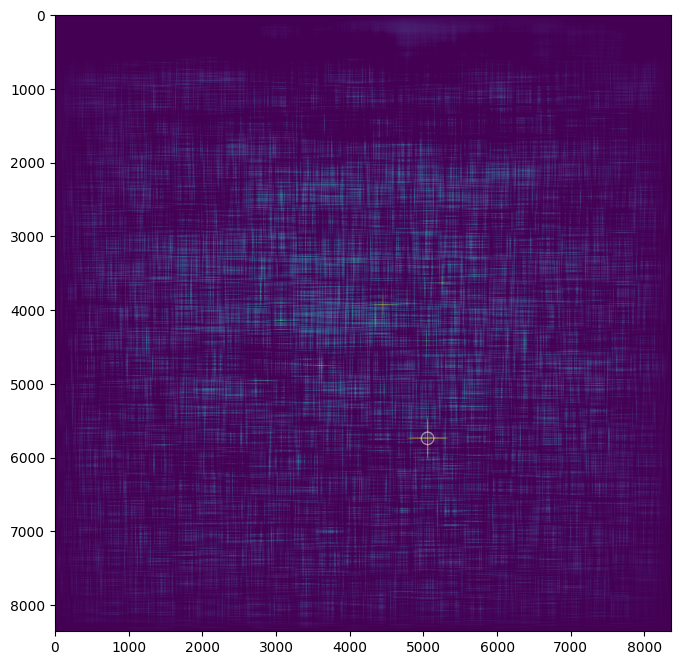

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=-composed.min())
ax.scatter(*argmax(composed)[::-1], s=80, facecolors='none', edgecolors='white', alpha=0.5)
plt.show()

After subtraction:

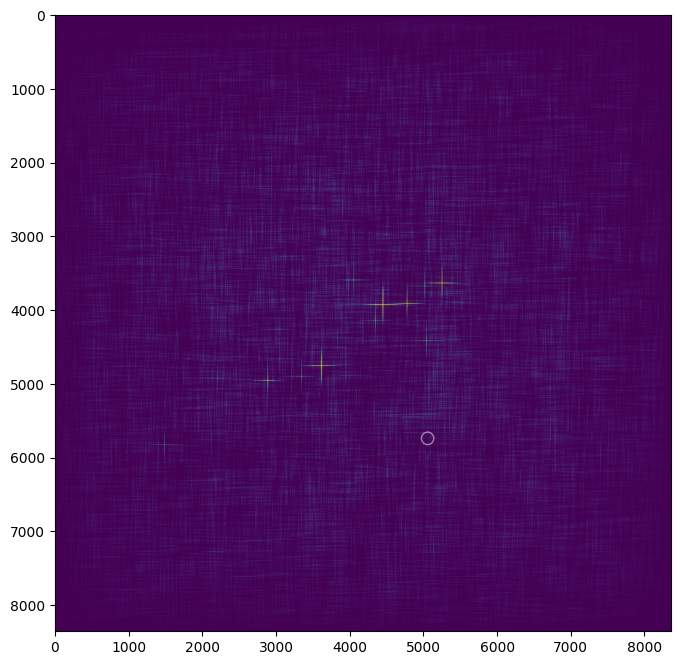

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed_residuals, vmin=0, vmax=-composed_residuals.min())
ax.scatter(*argmax(composed)[::-1], s=80, facecolors='none', edgecolors='white', alpha=0.5)
plt.show()

This technique is fundamental to the IROS (Iterative Removal of Sources) algorithm, which progressively reveals fainter sources by removing brighter ones from the field.

## Accessing Documentation

The library includes comprehensive documentation for all its functions and classes. You can access this documentation in Jupyter notebooks in two ways:

```python
# Using IPython's ? syntax
?fun  # Shows brief documentation
??fun # Shows full source code and documentation

# Using Python's built-in help
help(fun)
```

For example:

In [34]:
?optimize

Signature:
optimize(
    camera: bloodmoon.mask.CodedMaskCamera,
    sky: <built-in function array>,
    arg_sky: tuple[int, int],
    vignetting: bool = True,
    psfy: bool = True,
    verbose: bool = False,
) -> tuple[float, float, float]
Docstring:
Perform two-stage optimization to fit a point source model to sky image data.

This function performs a two-stage optimization:
1. Coarse optimization of fluence only, keeping position fixed
2. Fine, simultaneous optimization of position and fluence.
   This step is warm-started with the flux value inferred from the coarse step.

The process uses different model at each stage to balance speed and accuracy.

Args:
    camera: CodedMaskCamera instance containing detector and mask parameters
    sky: 2D array of the reconstructed sky image to fit
    arg_sky: Initial guess for source position as (row, col) indices
    vignetting: If true, the model used for optimization will simulate vignetting.
    psfy: If true, the model used for optimiz